In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
artists = 'dataset/artists.csv'
tracks = 'dataset/tracks.csv'

index_col = 0
df_artists = pd.read_csv(artists, sep=';', index_col=index_col)
df_tracks = pd.read_csv(tracks, index_col=index_col)

pd.set_option('display.max_columns', None)

## 💾 Optimizing Data Types for Efficiency

Before we proceed with cleaning and analysis, it's essential to ensure our DataFrames use the most **memory-efficient and appropriate data types**. Converting low-cardinality string columns (like `gender` and `nationality`) to the **`category`** dtype significantly reduces memory usage.

We'll also ensure all date columns are correctly parsed as **`datetime`** objects, and descriptive text fields are designated as the modern **`string`** dtype. For integer columns that contain `NaN` values, we use the nullable integer type **`Int64`**.

This step makes subsequent operations faster and more memory-friendly.

In [3]:
df_artists['gender'] = df_artists['gender'].astype('category')
df_artists['nationality'] = df_artists['nationality'].astype('category')
df_artists['country'] = df_artists['country'].astype('category')
df_artists['region'] = df_artists['region'].astype('category')
df_artists['province'] = df_artists['province'].astype('category')
df_artists['birth_place'] = df_artists['birth_place'].astype('category')
df_artists['birth_date'] = pd.to_datetime(df_artists['birth_date'], errors='coerce')
df_artists['active_start'] = pd.to_datetime(df_artists['active_start'], errors='coerce')
df_artists['description'] = df_artists['description'].astype('string')
df_artists['name'] = df_artists['name'].astype('string')

In [4]:
df_tracks['id_artist'] = df_tracks['id_artist'].astype('category')
df_tracks['id_album'] = df_tracks['id_album'].astype('category')
df_tracks['language'] = df_tracks['language'].astype('category')
df_tracks['album_type'] = df_tracks['album_type'].astype('category')
df_tracks['stats_pageviews'] = pd.to_numeric(df_tracks['stats_pageviews'], errors='coerce')
df_tracks['year'] = pd.to_numeric(df_tracks['year'], errors='coerce')
df_tracks['month'] = pd.to_numeric(df_tracks['month'], errors='coerce')
df_tracks['day'] = pd.to_numeric(df_tracks['day'], errors='coerce')
df_tracks['popularity'] = pd.to_numeric(df_tracks['popularity'], errors='coerce')
df_tracks['disc_number'] = df_tracks['disc_number'].astype('Int64')
df_tracks['track_number'] = df_tracks['track_number'].astype('Int64')
df_tracks['explicit'] = df_tracks['explicit'].astype('bool')
df_tracks['modified_popularity'] = df_tracks['modified_popularity'].astype('bool')
df_tracks['album_release_date'] = pd.to_datetime(df_tracks['album_release_date'], errors='coerce')
df_tracks['name_artist'] = df_tracks['name_artist'].astype('string')
df_tracks['full_title'] = df_tracks['full_title'].astype('string')
df_tracks['title'] = df_tracks['title'].astype('string')
df_tracks['featured_artists'] = df_tracks['featured_artists'].astype('string')
df_tracks['primary_artist'] = df_tracks['primary_artist'].astype('string')
df_tracks['album_name'] = df_tracks['album_name'].astype('string')
df_tracks['album'] = df_tracks['album'].astype('string')
df_tracks['album_image'] = df_tracks['album_image'].astype('string')
df_tracks['lyrics'] = df_tracks['lyrics'].astype('string')

In [5]:
import ast # Import the Abstract Syntax Tree module for safe evaluation

# Assuming your DataFrame is df_tracks and it's already loaded

def safe_literal_eval(value):
    """
    Safely converts a string representation of a list into a Python list.
    Handles NaN/missing values by returning an empty list or pd.NA.
    """
    if pd.isna(value) or value in (None, 'NaN', ''):
        # Return an empty list for missing values if you plan to iterate over it
        return []
    try:
        # Use ast.literal_eval for safe conversion of string-to-list
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        # Handle cases where the string is malformed or not a list structure
        print(f"Warning: Could not convert value: {value}")
        return [] # Default to empty list on failure

# Apply the conversion to both columns
df_tracks['swear_IT_words'] = df_tracks['swear_IT_words'].apply(safe_literal_eval)
df_tracks['swear_EN_words'] = df_tracks['swear_EN_words'].apply(safe_literal_eval)

## 🕵️ Data Validation: Checking and Correcting Primary Key Duplicates

For the data preparation phase, we start by performing a crucial check of the primary IDs for rows in both our DataFrames to check for potential duplicates. Ensuring unique identifiers is **foundational** for reliable joins and accurate analysis later on. 

A formal review of the primary ID columns yielded the following observations:

* **`df_tracks`**: Inspection of the track ID column revealed **73 instances of duplicated identifiers**. To guarantee that each record is uniquely identifiable and to maintain the principle of one-to-one entity mapping, these duplicated rows will be managed immediately. IDs are of the format $\text{TR\#\#\#\#\#\#}$, so we generate new IDs compliant with this format to replace duplicated ones.
* **`df_artists`**: The artist ID column was found to be **entirely sound**, presenting no instances of duplicate IDs. Consequently, no corrective action is required for this DataFrame regarding its primary keys.

The code below first validates the counts, displays a sample of the duplicates, and then executes the custom logic to **generate unique, non-colliding IDs** to replace the duplicated indices in `df_tracks`.

In [6]:
# 1. Creare un set di tutti gli ID esistenti per un controllo rapido
existing_tracks_ids = set(df_tracks.index)
existing_artists_ids = set(df_artists.index)

# 2. Identificare le posizioni (indice booleano) degli indici duplicati.
#    Usiamo keep='first' per segnare solo la seconda, terza, ecc. occorrenza.
duplicate_mask_tracks = df_tracks.index.duplicated()
duplicate_mask_artists = df_artists.index.duplicated()
num_duplicates_tracks = duplicate_mask_tracks.sum()
num_duplicates_artists = duplicate_mask_artists.sum()
print("number of duplicate index for tracks:", num_duplicates_tracks)
print("number of duplicate index for artists:", num_duplicates_artists)

number of duplicate index for tracks: 73
number of duplicate index for artists: 0


In [7]:
# 1. Creare una maschera per identificare TUTTE le righe (inclusa la prima)
#    che hanno un indice duplicato.
all_duplicates_mask = df_tracks.index.duplicated(keep=False)

# 2. Filtrare il DataFrame per ottenere solo queste righe
df_duplicate_groups = df_tracks[all_duplicates_mask]

# 3. Ordinare per indice. Questo è fondamentale per vedere
#    le righe con lo stesso indice una accanto all'altra.
df_duplicate_groups_sorted = df_duplicate_groups.sort_index()

# 4. Stampare i gruppi di duplicati
if not df_duplicate_groups_sorted.empty:
    print("Mostro tutte le righe che hanno un indice duplicato, ordinate per ID:")
    # Stampiamo le prime 30 (o modifica il numero se vuoi vederne di più)
    print(df_duplicate_groups_sorted.head(10))
else:
    # Questo scenario si verifica se num_duplicates (dal tuo codice) era 0
    print("Nessuna riga con indice duplicato trovata.")

Mostro tutte le righe che hanno un indice duplicato, ordinate per ID:
            id_artist      name_artist  \
id                                       
TR108862  ART56320683    Bassi Maestro   
TR108862  ART07127070      Noyz Narcos   
TR135764  ART73965015           Ghemon   
TR135764  ART86549066       Emis Killa   
TR190585  ART78209349             Coez   
TR190585  ART66932389           Piotta   
TR192351  ART81071062        Club Dogo   
TR192351  ART88792008    Jake La Furia   
TR205970  ART80977821  Jack The Smoker   
TR205970  ART08456301          Rancore   

                                                 full_title  \
id                                                            
TR108862                         Sushi Bar by Bassi Maestro   
TR108862                    SPINE by Noyz Narcos (Ft. Coez)   
TR135764                   Nessuno vale quanto te by Ghemon   
TR135764          Giovani eroi by Emis Killa (Ft. Not Good)   
TR190585     Nei treni la notte by Coez (Ft. Fr

In [8]:
import random

# --- 1. Identify Duplicated Rows and Count ---
# Find the boolean mask for rows where the ID (index) is duplicated,
# keeping only the duplicates *after* the first occurrence.
duplicated_mask = df_tracks.index.duplicated(keep='first')
num_duplicates_to_replace = duplicated_mask.sum() # Should be 73
print(num_duplicates_to_replace)

# --- 2. Define ID Generation Helper ---
def format_track_id(number, prefix='TR', padding=6):
    """Formats a number into a TRXXXXXX string."""
    # Uses f-string formatting to zero-pad the number to 6 digits
    return f"{prefix}{number:0{padding}d}"

# --- 3. Generate New Unique IDs with Collision Check ---

# Convert the existing index to a set for O(1) average time complexity lookups
existing_ids = set(df_tracks.index)
new_track_ids = []

# Range for 6-digit numbers (000000 to 999999)
MIN_ID = 0
MAX_ID = 999999 

print(f"Generating {num_duplicates_to_replace} random unique IDs...")

while len(new_track_ids) < num_duplicates_to_replace:
    # Generate a random 6-digit number
    random_num = random.randint(MIN_ID, MAX_ID)
    
    # Format it to the "TRXXXXXX" string
    new_id = format_track_id(random_num)
    
    # Check for collision against all existing IDs
    if new_id not in existing_ids:
        new_track_ids.append(new_id)
        # Immediately add the new ID to the existing_ids set to prevent
        # generating the same random ID twice during this loop
        existing_ids.add(new_id)

print("Finished generating unique IDs.")

# --- 4. Replace Duplicated IDs in the DataFrame Index ---

# Get the actual index values that need to be replaced (the index values of the duplicated rows)
indices_to_replace = df_tracks.index[duplicated_mask]

# Create a Series of the new IDs, matching the indices (positions) of the duplicated rows
new_ids_series = pd.Series(
    new_track_ids,
    index=indices_to_replace
)

# Replace the duplicated index values in-place
df_tracks.index.values[duplicated_mask] = new_ids_series.values

# --- Verification ---
print(f"\nGenerated {len(new_track_ids)} new unique IDs.")
print(f"Example new ID: {new_track_ids[0]}")
print(f"Check for duplicates after replacement: {df_tracks.index.duplicated().any()}")

73
Generating 73 random unique IDs...
Finished generating unique IDs.

Generated 73 new unique IDs.
Example new ID: TR699970
Check for duplicates after replacement: False


## 🧹 Removing Redundant Artist Columns

We discovered that **`name_artist`**, **`name`**, and **`primary_artist`** all highlight the same information, creating unnecessary redundancy in our dataset. To determine which columns to keep, we performed a thorough **normalization and comparison analysis**.

After joining the tracks and artists DataFrames, we implemented a **helper function** to normalize all artist-related string columns. This normalization process includes:
- Converting to lowercase
- Removing accents (e.g., 'è' → 'e')  
- Stripping special characters
- Trimming whitespace

We applied this normalization to **`name`**, **`primary_artist`**, **`name_artist`**, and **`featured_artists`** to ensure a fair comparison. Our analysis revealed that **`primary_artist`** and **`name_artist`** are *identical* after normalization, while **`name`** contains the same unique values but with a slightly altered version for some artists, hence still being redundant.

We also checked for **self-titled tracks** (where the track name matches the artist name) and examined edge cases like featured artists. Based on these findings, we confidently **dropped** the redundant **`name`** and **`primary_artist`** columns, retaining only **`name_artist`** as this column (equivalent to **`primary_artist`**) matches the same version of how the artist name is written in **`featured_artists`**.


In [9]:
df = df_tracks.join(df_artists, on='id_artist')

In [10]:
# Funzione helper per la normalizzazione
def normalize_series(series):
    # 1. Minuscolo
    s = series.str.lower()
    
    # 2. Rimuove accenti (es. 'è' -> 'e')
    # NFKD normalizza i caratteri, 'ascii' rimuove ciò che non è ascii (accenti)
    s = s.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    
    # 3. Rimuove caratteri speciali (tutto tranne lettere, numeri, spazi)
    # [^\w\s] significa "tutto ciò che NON è un carattere di parola (\w) o uno spazio (\s)"
    s = s.str.replace(r'[^\w\s]', '', regex=True)
    
    # 4. Rimuove spazi extra all'inizio/fine
    s = s.str.strip()
    
    # (Opzionale) Sostituisce spazi multipli con uno singolo
    s = s.str.replace(r'\s+', ' ', regex=True)


    return s

In [11]:
# Applichiamo la normalizzazione alle tre colonne
df['name'] = normalize_series(df['name'])
df['primary_artist'] = normalize_series(df['primary_artist'])
df['name_artist'] = normalize_series(df['name_artist'])
df['featured_artists'] = normalize_series(df['featured_artists'])

In [12]:
# Controlla se le due colonne sono SEMPRE identiche
are_artists_identical = (df['primary_artist'] == df['name_artist']).all()

if are_artists_identical:
    print("Analisi: 'primary_artist' e 'name_artist' sono sempre identici dopo la normalizzazione.")
else:
    print("Analisi: 'primary_artist' e 'name_artist' NON sono sempre identici.")
    
    diff_df = df[df['primary_artist'] != df['name_artist']]
    print(diff_df[['primary_artist', 'name_artist', 'primary_artist', 'name_artist']].head())

Analisi: 'primary_artist' e 'name_artist' sono sempre identici dopo la normalizzazione.


In [13]:
# Cerca tracce omonime (dove il nome della traccia è uguale al nome dell'artista)
self_titled_tracks = df[df['name'] != df['primary_artist']]
print(self_titled_tracks[['name', 'primary_artist']])


                  name primary_artist
id                                   
TR317207   gue pequeno            gue
TR446826   gue pequeno            gue
TR228275   gue pequeno            gue
TR697556   gue pequeno            gue
TR391415   gue pequeno            gue
...                ...            ...
TR794750  samuel heron   samuel costa
TR102539  samuel heron   samuel costa
TR178809   joey funboy       joey ita
TR589443   joey funboy       joey ita
TR735987   joey funboy       joey ita

[870 rows x 2 columns]


In [14]:
df.drop(columns=['name', 'primary_artist'], inplace=True)

Active_end column is completely empty so we can drop it

In [15]:
df.drop(columns=['active_end'], inplace=True)

## 🔍 Analyzing `full_title`

### `full_title` vs `title` Redundancy

The **`full_title`** and **`title`** attributes should theoretically correspond, as both identify the track's name. However, **`full_title`** contains additional information by appending the performer with **"by (artist_name)"** and featuring artists with **"Ft. (featured_artists)"**.

This explains why **`full_title`** has more unique values compared to **`title`**. However, by examining the actual title name contained in the first portion of **`full_title`**, we notice that the two columns do in fact correspond to the same underlying track name.

We performed a **regex-based extraction and normalization** to verify this relationship holds across *all* records. The process involved:

- **Extracting** the title portion from **`full_title`** by splitting at the last occurrence of `" by"`
- **Normalizing smart quotes and apostrophes** (e.g., `'` → `'`, `"` → `"`) to handle encoding differences
- **Standardizing whitespace** by stripping leading/trailing spaces and collapsing multiple spaces into one

After these comprehensive normalization steps, we confirmed that the extracted title from **`full_title`** is *identical* to **`title`** across all rows. This allows us to confidently **discard** one of the two columns, eliminating redundancy while preserving complete information.

This verification ensures data integrity and simplifies our schema for future analysis. ✅

In [16]:
def normalize_title(series):
    """
    Normalize a pandas Series containing titles by:
    - Replacing smart quotes/apostrophes with straight ones
    - Stripping leading/trailing whitespace
    - Collapsing multiple spaces into single spaces
    """
    # Normalize smart apostrophes
    s = series.str.replace('’', "'", regex=False)
    s = s.str.replace('‘', "'", regex=False)

    # Normalize smart double quotes
    s = s.str.replace('“', '"', regex=False)
    s = s.str.replace('”', '"', regex=False)
    
    # Normalize whitespace
    s = s.str.strip()
    s = s.str.replace(r'\s+', ' ', regex=True)
    
    return s

In [17]:
df_title = df_tracks[['full_title', 'title']].copy()

# Extract title portion from full_title
split_series = df_title['full_title'].str.rsplit(' by', n=1)
df_title['cleaned_attribute'] = split_series.str[0]

# Apply normalization to both columns
df_title['cleaned_attribute'] = normalize_title(df_title['cleaned_attribute'])
df_title['title'] = normalize_title(df_title['title'])

# Compare results
are_columns_equal_final = (df_title['cleaned_attribute'] == df_title['title']).all()
print(f"Are the columns equal after normalization? {are_columns_equal_final}")

# Check the remaining mismatched rows (should now be 0)
final_mismatched_rows = df_title[df_title['cleaned_attribute'] != df_title['title']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

Are the columns equal after normalization? True
Number of rows still unequal: 0


## 🎵 Validating Artist and Featured Artists from `full_title`

Having established that **`full_title`** contains redundant information about track titles, we now investigate whether the **artist** and **featured artists** information embedded in **`full_title`** matches the dedicated columns **`name_artist`** and **`featured_artists`**.

The **`full_title`** follows the pattern: `"Track Name by Artist (Ft. Featured Artists)"` or `"Track Name by Artist, Featured Artist 1, ... & Featured Artist N"`. We perform a **multi-step extraction and normalization** process to validate this relationship.

In [18]:
df_artist_and_feat = df_tracks[['full_title', 'name_artist', 'featured_artists']].copy()

df_artist_and_feat['name_artist'] = normalize_title(df_artist_and_feat['name_artist'])
df_artist_and_feat['featured_artists'] = normalize_title(df_artist_and_feat['featured_artists'])
df_artist_and_feat['full_title'] = normalize_title(df_artist_and_feat['full_title'])

# --- Step 1: Extract 'artist_and_feat' (Artist + Features) ---
split_series_1 = df_artist_and_feat['full_title'].str.rsplit(' by', n=1)
df_artist_and_feat['artist_and_feat'] = split_series_1.str[1]
df_artist_and_feat.drop(columns=['full_title'], inplace=True)

# --- Step 2: Separate 'cleaned_artist' from 'cleaned_feat' ---
split_series_2 = df_artist_and_feat['artist_and_feat'].str.rsplit('(Ft.', n=1)
df_artist_and_feat['cleaned_artist'] = split_series_2.str[0]
df_artist_and_feat['cleaned_feat'] = split_series_2.str[1].str.replace(r'\)$', '', regex=True)

# --- NEW: Convert & to , BEFORE extracting the artist ---
df_artist_and_feat['cleaned_artist'] = df_artist_and_feat['cleaned_artist'].str.replace('&', ',', regex=False)

# --- Extract primary artist by splitting at the FIRST comma ---
split_series_3 = df_artist_and_feat['cleaned_artist'].str.split(',', n=1)
df_artist_and_feat['cleaned_artist'] = split_series_3.str[0]

# The remaining artists after the first comma become features
remaining_artists = split_series_3.str[1]

# --- Move remaining artists to 'cleaned_feat' if '(Ft....)' was empty ---
mask_empty_feat = df_artist_and_feat['cleaned_feat'].isna() | (df_artist_and_feat['cleaned_feat'].str.strip() == '')

df_artist_and_feat['cleaned_feat'] = df_artist_and_feat['cleaned_feat'].mask(
    mask_empty_feat,
    remaining_artists.fillna('').str.strip()
)

# --- Strip whitespace from cleaned_artist ---
df_artist_and_feat['cleaned_artist'] = df_artist_and_feat['cleaned_artist'].str.strip()

# --- Final Comparison ---
are_names_equal_final = (df_artist_and_feat['cleaned_artist'] == df_artist_and_feat['name_artist']).all()
print(f"Are the artist names equal? {are_names_equal_final}")

# Identify and print the remaining mismatched rows
final_mismatched_rows = df_artist_and_feat[df_artist_and_feat['cleaned_artist'] != df_artist_and_feat['name_artist']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

# if len(final_mismatched_rows) > 0:
#     print("\nSample of remaining mismatched rows:")
#     rows_to_display = final_mismatched_rows.head(10)
#     print(rows_to_display[['name_artist', 'cleaned_artist']])
    
#     print("\nFirst Mismatched Row Details:")
#     first_id = rows_to_display.index[0]
#     print(f"name_artist: '{df_artist_and_feat['name_artist'].loc[first_id]}'")
#     print(f"cleaned_artist: '{df_artist_and_feat['cleaned_artist'].loc[first_id]}'")

# df_artist_and_feat.drop(columns=['artist_and_feat'], inplace=True)
# print(df_artist_and_feat[['name_artist', 'cleaned_artist']].head(10))

Are the artist names equal? True
Number of rows still unequal: 0


After applying comprehensive normalization to compare **`cleaned_feat`** (extracted from **`full_title`**) with the original **`featured_artists`** column, we identified **413 mismatched rows**.

### Key Findings

The mismatches reveal a systematic pattern: in many cases, the original **`featured_artists`** column is *empty* while **`cleaned_feat`** contains valid artist names extracted from **`full_title`**. This indicates that **`full_title`** actually contains *more complete* information about featured artists than the dedicated **`featured_artists`** column.

In [19]:
def sort_artists(series):
    """
    Normalize and sort a pandas Series containing artist names by:
    - Replacing '&' with ',' for consistent delimiter
    - Splitting by comma into individual artists
    - Stripping whitespace from each artist name
    - Sorting artists alphabetically
    - Rejoining into a single comma-separated string
    
    Parameters:
    -----------
    series : pd.Series
        A pandas Series containing artist names (can be comma or ampersand-separated)
    
    Returns:
    --------
    pd.Series
        A normalized Series with alphabetically sorted, comma-separated artist names
    """
    # Replace & with , for consistent delimiter
    s = series.str.replace('&', ',', regex=False)
    
    # Split by comma, strip whitespace, and filter out empty strings
    list_artists = s.str.split(',').apply(
        lambda x: [item.strip() for item in x if item.strip()] if isinstance(x, list) else []
    )
    
    # Sort alphabetically
    sorted_artists = list_artists.apply(lambda x: sorted(x))
    
    # Rejoin into comma-separated string
    normalized_series = sorted_artists.apply(lambda x: ', '.join(x))
    
    return normalized_series

In [20]:
df_artist_and_feat['featured_artists'] = sort_artists(df_artist_and_feat['featured_artists'])
df_artist_and_feat['cleaned_feat'] = sort_artists(df_artist_and_feat['cleaned_feat'])

# Identify and print the remaining mismatched rows using the normalized series
final_mismatched_rows = df_artist_and_feat[df_artist_and_feat['cleaned_feat'] != df_artist_and_feat['featured_artists']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

# Print the remaining mismatched rows for inspection
if len(final_mismatched_rows) > 0:
    print("\nSample of remaining mismatched rows:")
    # We display the original columns and the two normalized versions for true inspection
    rows_to_display = final_mismatched_rows.head(10)
    print(rows_to_display[['featured_artists', 'cleaned_feat']])

    print("\nCleaned Series for First Mismatched Row (After Aggressive Strip):")
    first_id = rows_to_display.index[0]
    # Use the normalized series for the clearest inspection
    print(f"featured_artists (normalized): '{df_artist_and_feat['featured_artists'].loc[first_id]}'")
    print(f"cleaned_feat (normalized): '{df_artist_and_feat['cleaned_feat'].loc[first_id]}'")

Number of rows still unequal: 413

Sample of remaining mismatched rows:
         featured_artists                                       cleaned_feat
id                                                                          
TR266736                   Friman (ITA), Mehdi (ITA), Mothz, Spender, The...
TR281032                                                           Manu Chao
TR811171                                                         Mara Sattei
TR822203                                                         Mara Sattei
TR397308                                                       Tiziano Ferro
TR212338                                                         Mara Sattei
TR372774                                                         Mara Sattei
TR993112                                                         Mara Sattei
TR444969                                                         Mara Sattei
TR479694                                                         Mara Sattei

Cle

In [21]:
df['featured_artists'] = normalize_series(df_artist_and_feat['cleaned_feat'])

df.drop(columns=['full_title'], inplace=True)

## Language attribute
Most present language for main lyrics are italian. english and polish. We checked most of these languages and they don't seem to respect the main language of the lyrics.

So we decided to run a SOTA language model to detect based on the tokens of he lyrics colmn the language of the track

In [22]:
import fasttext
import regex as re  

df_language = df_tracks[['language', 'lyrics', 'n_sentences']].copy()


df_language['lyrics_normalized'] = normalize_series(df_language['lyrics'])

print(df_language['lyrics_normalized'].head())

id
TR934808    opla ah bdope chiama due b mi candiderei come ...
TR760029    greg willen non dormire brrpoh tttroppi cocale...
TR916821    mothz yeah yeah yeahyeah bdope chiama due b po...
TR480968    designer sui vestiti penso di essere un outlet...
TR585039    bdope yeah vuole solo me non fare la gelosa no...
Name: lyrics_normalized, dtype: object


In [23]:
MODEL_PATH = 'lid.176.bin'

model = fasttext.load_model(MODEL_PATH)

def detect_language_safe(text, model):
    """
    Safely detects the language and confidence using FastText.
    Fortified to handle DataFrame edge cases (NaN, None, short strings).
    Returns a tuple (language_code, confidence_score) or (None, 0.0).
    """
    # 1. Explicitly check for NaN/None and ensure string conversion
    if pd.isna(text):
        return None, 0.0
    
    # Ensure it's a string and strip whitespace
    text_str = str(text).strip()
    
    # FIX: Remove newline and carriage return characters, as FastText requires a single line
    text_str = text_str.replace('\n', ' ').replace('\r', ' ')
    
    # FastText needs a minimum amount of text (let's keep the minimum length check)
    if len(text_str) < 10: 
        # Optionally log which records were too short
        # print(f"Skipping record due to short length: {text_str[:10]}...")
        return None, 0.0
    
    try:
        # k=1 asks for the single best prediction
        predictions = model.predict(text_str, k=1) 
        
        # predictions[0] is the label list: ['label__it']
        # predictions[1] is the probability list: [0.99]
        label = predictions[0][0].replace('__label__', '')
        confidence = predictions[1][0]
        
        return label, confidence
    except Exception as e:
        # If an exception is still caught, print a detailed message 
        # to help diagnose the specific content causing the crash.
        print(f"FastText Prediction failed for input starting: '{text_str[:50]}...'")
        print(f"Error details: {e}")
        return None, 0.0

results = df_language['lyrics_normalized'].apply(
    lambda x: detect_language_safe(x, model)
)

# Unpack the Series of tuples into the two new columns

# The first element of the tuple is the language code
df_language['most_probable_language'] = results.apply(lambda x: x[0])

# The second element of the tuple is the confidence score
df_language['confidence'] = results.apply(lambda x: x[1])

# Displaying the new columns (optional)
print(df_language[['language', 'most_probable_language', 'confidence', 'n_sentences']].head())

         language most_probable_language  confidence  n_sentences
id                                                               
TR934808       pl                     it    0.961070        102.0
TR760029       en                     it    0.901658         56.0
TR916821       en                     it    0.948407         88.0
TR480968       it                     it    0.946251         37.0
TR585039       en                     it    0.979265         48.0


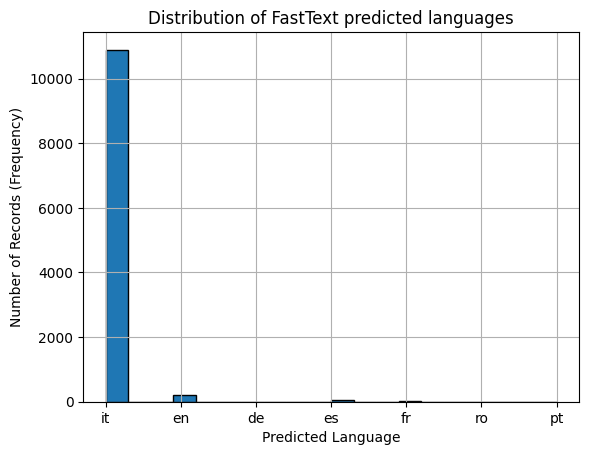

most_probable_language
it    10891
en      201
es       50
fr       10
de        5
pt        4
ro        2
Name: count, dtype: int64


In [39]:
import pandas as pd
# Assuming df_language is your DataFrame with the 'confidence' column

# Import the necessary plotting library for display
import matplotlib.pyplot as plt 

df_language['most_probable_language'].hist(
    bins=20, # Number of bins (intervals) for the histogram
    edgecolor='black'
)

plt.title('Distribution of FastText predicted languages')
plt.xlabel('Predicted Language')
plt.ylabel('Number of Records (Frequency)')
plt.show()


print(df_language['most_probable_language'].value_counts())

df['language'] = df_language['most_probable_language']

In [47]:
# 1. Create the boolean mask
df_1_sentence = df['n_sentences'] <= 1

# 2. Count the rows being affected (Correct use of sum())
rows_to_nullify = df_1_sentence.sum()
print(f"The number of rows/values that contain 1 or fewer sentences is: **{rows_to_nullify}**")

# 3. Define the columns to nullify
linguistic_columns = ['language', 'swear_IT', 'swear_EN', 
                      'swear IT words', 'swear_EN_words', 'n_sentences', 
                      'n_tokens', 'tokens_per_sent', 'avg_token_per_clause', 
                      'explicit', 'lyrics']

# 4. Apply the mask to the DataFrame df (This is the correct operation)
df.loc[df_1_sentence, linguistic_columns] = pd.NA

The number of rows/values that contain 1 or fewer sentences is: **127**


/tmp/ipykernel_6033/3721270105.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df_1_sentence, linguistic_columns] = pd.NA


## album, album_name, album id

While the column album seems more reasonable and coherent, it contains multiple null values.
Some album in "album_name" appear truncated and incomplete.

We decided to keep the normalization for better readability and to have normalized occurrences.

To create a new correct version of the column showing the album relative to every tracks we decided to do 3 major choices:

    #Choice 1 (for null 'album'): Use 'album_name_norm',
    
    #Choice 2 (for Mismatch): Use 'album_norm',
    
    #Choice 3 (for Match): mantain 'album_norm' (the same with 'album_name_norm')

In [26]:
import numpy as np
import random

print("--- Creazione di 'correct_album' ---")

# Applica la normalizzazione alle due colonne originali
df['album_norm'] = normalize_series(df['album'])
df['album_name_norm'] = normalize_series(df['album_name'])

# Definisci le condizioni per la colonna 'correct_album'
conditions = [
    (df['album'].isnull()), # Priorità 1: Se 'album' è nullo...
    (df['album_norm'] != df['album_name_norm']), # Priorità 2: Se c'è mismatch...
    (df['album_norm'] == df['album_name_norm'])  # Priorità 3: Se c'è match...
]

# Definisci le scelte corrispondenti
choices = [
    df['album_name_norm'], # ...usa 'album_name_norm'
    df['album_norm'],      # ...usa 'album_norm'
    df['album_norm']       # ...usa 'album_norm'
]

# Crea la colonna 'correct_album'
df['correct_album'] = np.select(conditions, choices, default=np.nan)
print("Colonna 'correct_album' creata con successo.")


print("\n--- [FASE 3]: Assegnazione di 'id_album_final' (Algoritmo 1-a-1) ---")

# --- 3.1: Preparazione ---

# Ordina gli album per frequenza (dà priorità agli album più grandi)
album_order = df['correct_album'].value_counts().index

# Filtra i dati per creare la mappa dei candidati
df_candidates = df.dropna(subset=['correct_album', 'id_album'])
track_counts = df_candidates.groupby(['correct_album', 'id_album']).size().to_frame('count')

# Ordina i candidati per album e poi per frequenza
track_counts = track_counts.sort_values(['correct_album', 'count'], ascending=[True, False])

# Crea un dizionario di liste di candidati: {'Album': ['id_più_freq', 'id_secondo_più_freq']}
all_id_candidates = track_counts.reset_index().groupby('correct_album')['id_album'].apply(list).to_dict()

# --- 3.2: Esecuzione del Loop ---

used_ids = set() # Set per gli ID già "presi"
final_album_to_id_map = {} # La nostra mappa pulita finale

def generate_new_id():
    new_id = f"ALB{random.randint(100000, 999999)}"
    while new_id in used_ids:
        new_id = f"ALB{random.randint(100000, 999999)}"
    return new_id

print(f"Inizio processamento di {len(album_order)} album per assegnazione ID...")

# Itera sugli album in ordine di priorità
for album_name in album_order:
    
    candidate_ids = all_id_candidates.get(album_name, []) # Lista di ID candidati
    assigned_id = None # Flag

    # Cerca il primo ID valido (non già usato)
    for potential_id in candidate_ids:
        if potential_id not in used_ids:
            assigned_id = potential_id
            used_ids.add(assigned_id) # "Prenota" l'ID
            final_album_to_id_map[album_name] = assigned_id
            break # Passa all'album successivo
    
    # Se non è stato trovato nessun ID valido (o non c'erano candidati)
    if assigned_id is None:
        new_id = generate_new_id()
        used_ids.add(new_id)
        final_album_to_id_map[album_name] = new_id

print("Processamento ID terminato. Mappa 1-a-1 creata.")

# --- 3.3: Applicazione Finale ---

# Applica la mappa pulita al DataFrame
df['id_album_final'] = df['correct_album'].map(final_album_to_id_map)

print("\n--- VERIFICA FINALE ---")

# Controlla la relazione 1-a-1
check_ids_per_album = df.groupby('correct_album')['id_album_final'].nunique()
check_albums_per_id = df.groupby('id_album_final')['correct_album'].nunique()

print(f"Album con più di 1 ID: {(check_ids_per_album > 1).sum()}")
print(f"ID con più di 1 Album: {(check_albums_per_id > 1).sum()}")

print("\n--- Esempio di 10 righe pulite: ---")
print(df[['correct_album', 'id_album', 'id_album_final']].sample(10))

--- Creazione di 'correct_album' ---
Colonna 'correct_album' creata con successo.

--- [FASE 3]: Assegnazione di 'id_album_final' (Algoritmo 1-a-1) ---


/tmp/ipykernel_6033/851805109.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  track_counts = df_candidates.groupby(['correct_album', 'id_album']).size().to_frame('count')


Inizio processamento di 1884 album per assegnazione ID...
Processamento ID terminato. Mappa 1-a-1 creata.

--- VERIFICA FINALE ---
Album con più di 1 ID: 0
ID con più di 1 Album: 0

--- Esempio di 10 righe pulite: ---
                      correct_album   id_album id_album_final
id                                                           
TR501039     la forza che scorre ep  ALB257981      ALB257981
TR602471       che bello essere noi  ALB301644      ALB301644
TR496713  aspetta un minuto mixtape  ALB831170      ALB309096
TR955863              cookie monsta  ALB447239      ALB447239
TR185259               fuori di qua  ALB108360      ALB749023
TR436288                       yang  ALB979676      ALB176814
TR799066         santana money gang  ALB254691      ALB254691
TR581348         ixc the lost album  ALB185917      ALB185917
TR836948  solo un uomo gold edition  ALB441104      ALB441104
TR293961                        wao  ALB764398      ALB764398


In [27]:
df['album'] = df['correct_album']
df.drop(columns=['album_name', 'album_norm', 'album_name_norm', 'correct_album'], inplace=True)
df['id_album'] = df['id_album_final']
df.drop(columns=['id_album_final'], inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_artist             11166 non-null  object        
 1   name_artist           11166 non-null  object        
 2   title                 11166 non-null  string        
 3   featured_artists      11166 non-null  object        
 4   language              11061 non-null  category      
 5   album                 11161 non-null  object        
 6   stats_pageviews       4642 non-null   float64       
 7   swear_IT              11166 non-null  int64         
 8   swear_EN              11166 non-null  int64         
 9   swear_IT_words        11166 non-null  object        
 10  swear_EN_words        11166 non-null  object        
 11  year                  10728 non-null  float64       
 12  month                 9969 non-null   float64       
 13  day        

## Stats page views

As considered in data understanding phase, almost 60% of records is missing (Nan) so we decided to drop the column.

In [29]:
df.drop(columns=['stats_pageviews'], inplace=True)

In [ ]:
total_tracks_per_album = df.groupby('album').size()

print("Total Tracks per Album (including duplicates):\n", total_tracks_per_album)

# --- Start of the requested validation logic ---

# 1. Map the total track count back into the main DataFrame 'df'.
# This creates a new column with the maximum expected track number for each row's album.
df['total_tracks_in_album'] = df['album'].map(total_tracks_per_album)

# 2. Ensure 'track_number' is numeric to support comparison.
# Using errors='coerce' turns non-numeric values (like strings 'A1' or 'Bonus') into NaN,
# which are automatically excluded from the comparison, preventing errors.
df['track_number'] = pd.to_numeric(df['track_number'], errors='coerce')

# 3. Create a boolean mask for tracks where track_number is greater than the total count.
# We also ensure 'track_number' is not NaN to avoid comparing missing values.
high_track_number_mask = (df['track_number'].notna()) & \
                         (df['track_number'] > df['total_tracks_in_album'])

# 4. Filter the DataFrame to show only the tracks that fail the check (the invalid ones).
tracks_with_invalid_number = df[high_track_number_mask].copy()

# 5. Select and display the relevant columns for inspection
result_columns = ['album', 'track_number', 'total_tracks_in_album']

if not tracks_with_invalid_number.empty:
    print("\n--- Tracks with Track Number > Total Album Count ---")
    print("These tracks likely indicate data entry errors (e.g., track 5 in a 3-track album).")
    print(tracks_with_invalid_number[result_columns].sort_values(by='album'))
else:
    print("\nNo tracks were found where the track number exceeds the total count of tracks in the album.")

# Optional: Clean up the temporary column
df.drop(columns=['total_tracks_in_album'], inplace=True)

# You can now use the 'tracks_with_invalid_number' DataFrame for further analysis or cleaning.

Total Tracks per Album (including duplicates):
 album
                         1
00                       1
0023                     1
1 2 3                    1
1 less g in the hood     1
                        ..
zingarello               1
zoe                      1
zonda                    1
zora la vampira          1
zzala                   11
Length: 1884, dtype: int64
